## Messari standardised subgraphs

https://github.com/messari/subgraphs

### saddle Finance

12/09/22

In [11]:
import pandas as pd
import numpy as np
import time
import requests
import datetime as dt

In [12]:
endpoint = 'https://api.thegraph.com/subgraphs/name/messari/saddle-finance-ethereum'

In [13]:
#Check if subgraph is up to date
query = """{
  _meta{
    block{
      timestamp
  		hash
      number
    }
    hasIndexingErrors
    deployment
  }
}"""
request = requests.post(endpoint, json={'query':query})
data = request.json()
#Check if it is ok to run i.e. within 5 days of today
print(dt.datetime.fromtimestamp(int(data['data']['_meta']['block']['timestamp'], base = 0)))
int(data['data']['_meta']['block']['timestamp'], base = 0) > (dt.datetime.today().timestamp() - 3600*24*5)

2022-09-12 16:32:05


True

6-month average volume

In [41]:
query = """{
  financialsDailySnapshots(first: 183, orderBy: timestamp, orderDirection: desc){
    id
    protocol{
      name
    }
    dailyVolumeUSD
    dailyTotalRevenueUSD
    dailySupplySideRevenueUSD
    dailyProtocolSideRevenueUSD
    timestamp
    blockNumber
  }
}
"""

In [42]:
request = requests.post(endpoint, json={'query':query})
data = request.json()

In [43]:
df = pd.json_normalize(data['data']['financialsDailySnapshots'])

In [44]:
df['dailyVolumeUSD'] = df['dailyVolumeUSD'].astype(float)

<AxesSubplot:>

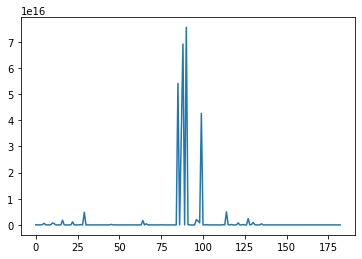

In [45]:
df['dailyVolumeUSD'].plot()

In [50]:
df['dailyVolumeUSD'].nsmallest(134).mean() #Volume USD issue

2502284.8276301883

6-Month Average TVL

In [51]:
#DefiLlama https://defillama.com/protocols/dexes 
lma = pd.read_csv("https://api.llama.fi/dataset/saddle-finance.csv")

In [52]:
lma

,Unnamed: 0,Date,Timestamp,Saddle Finance,Saddle Finance.1,Saddle Finance.2,Saddle Finance.3,Saddle Finance.4,Saddle Finance.5,Saddle Finance.6,...,Saddle Finance.143,Saddle Finance.144,Saddle Finance.145,Saddle Finance.146,Saddle Finance.147,Saddle Finance.148,Saddle Finance.149,Saddle Finance.150,Saddle Finance.151,Saddle Finance.152
0,NaN,NaN,NaN,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes,...,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes,Dexes
1,NaN,NaN,NaN,optimism,ethereum,kava,evmos,arbitrum,Total,fantom,...,Total,Total,Total,Total,Total,fantom,fantom,fantom,fantom,fantom
2,NaN,NaN,NaN,TVL,TVL,TVL,TVL,TVL,TVL,TVL,...,Tokens,Tokens,Tokens,Tokens,Tokens,Tokens,Tokens,Tokens,Tokens,Tokens
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,USDS,USX,tether,dai,SCHF,usd-coin,USDT,FRAX,USDC,ALUSD
4,NaN,07/03/2021,1.615075e+09,NaN,53426351.37,NaN,NaN,NaN,53426351.37,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,NaN,08/09/2022,1.662595e+09,2857820.769685244,34595109.78921851,0.20015,3375.4516739028836,3985563.694685812,41442790.963357694,921.0579442336799,...,628429.5312887768,506869.57771990064,0.05,0.05,NaN,NaN,NaN,803.7089622430191,117.968818,NaN
555,NaN,09/09/2022,1.662682e+09,2865436.9746894035,34637574.691984914,0.20015,3390.6312259796887,4525797.187740381,42033119.32453833,919.6387476539795,...,874188.6923730549,506869.57771990064,0.05,0.05,NaN,NaN,NaN,792.4740377533112,129.246466,NaN
556,NaN,10/09/2022,1.662768e+09,2908458.49005867,35298989.66420811,0.2002,3377.9170954611172,5477155.38634822,43688902.97386057,921.3159501166663,...,1157002.351112716,506869.57771990064,0.05,0.05,NaN,NaN,NaN,752.2518174969576,169.174044,NaN
557,NaN,11/09/2022,1.662854e+09,3085560.29336869,35858766.45445004,0.20025,3373.4746976425045,6541911.024364816,45490533.087411396,921.6402802130394,...,1346796.8616734727,506869.57771990064,0.05,0.05,NaN,NaN,NaN,781.0360323188092,140.820361,NaN


In [53]:
lma.iloc[:,4]

0                   Dexes
1                ethereum
2                     TVL
3                     NaN
4             53426351.37
              ...        
554     34595109.78921851
555    34637574.691984914
556     35298989.66420811
557     35858766.45445004
558     36649086.55675181
Name: Saddle Finance.1, Length: 559, dtype: object

In [54]:
#Just eth currently can take total by changing the header
lma.iloc[-183:, 4].astype(float).mean()

81858127.72264962

Largest Pool Concentration

In [55]:
df = pd.DataFrame()
ts = 0

while True:
    sl = len(df)
    query = """
{
  liquidityPools(first:1000, orderBy: createdTimestamp, orderDirection: asc, where: {createdTimestamp_gt: """+f'"{ts}"'+"""}){
    id
    name
    totalValueLockedUSD
    cumulativeVolumeUSD
    createdTimestamp
    createdBlockNumber
  }
}
"""
    request = requests.post(endpoint, json={'query':query})
    data = request.json()

    pool = pd.json_normalize(data['data']['liquidityPools'])
    df = df.append(pool)
    df.drop_duplicates(inplace=True)
    if len(df) == sl:
      break
    ts = df['createdTimestamp'].max()


/tmp/ipykernel_66260/2291472997.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pool)


In [56]:
df

,id,name,totalValueLockedUSD,cumulativeVolumeUSD,createdTimestamp,createdBlockNumber
0,0x4f6a43ad7cba042606decaca730d4ce0a57ac62e,Saddle tBTC/WBTC/renBTC/sBTC,203704.282346935900237400728312,345237865278045193.4724972762325069,1611057088,11685572
1,0x3911f80530595fbd01ab1516ab61255d75aeb066,Saddle DAI/USDC/USDT,12954.777465613017142821,39911827.346622506694863984,1616117925,12066229
2,0xdec2157831d6abc3ec328291119cc91b337272b5,Saddle WETH/vETH2,216311.038672528270819670364,26436088.1896051515563041831639355,1617838432,12195714
3,0xa6018520eaacc06c30ff2e1b3ee2c7c22e64196a,Saddle WETH/alETH/sETH,2701212.60427951387274052854018,491311838.1943447635610914764752855,1623701930,12634694
4,0xc69ddcd4dfef25d8a793241834d4cc4b3668ead6,Saddle alUSD/FEI/FRAX/LUSD,10916694.933523967747195661,860244069.8079564781929427315,1624601841,12701652
5,0xacb83e0633d6605c5001e2ab59ef3c745547c8c7,Saddle DAI/USDC/USDT V2,755787.557931565657597772,54605525.5978472302693218205,1626293129,12827153
6,0x0c8bae14c9f9bf2c953997c881befac7729fd314,Saddle sUSD/saddleUSD-V2,607.073696140398706261,216140.6044913456191537835,1627451981,12912720
7,0xdf3309771d2bf82cb2b6c56f9f5365c8bd97c4f2,Saddle WBTC/renBTC/sBTC,825445.77388662899096607304,213024329.8066530523499943036869715,1629751863,13083826
8,0xf74ebe6e5586275dc4ced78f5dbef31b1efbe7a5,Saddle tBTCv2/saddleWRenSBTC,55111.025920654704885486,14859380.86427285728039790411237,1630370737,13130191
9,0x3f1d224557afa4365155ea77ce4bc32d5dae2174,Saddle wCUSD/saddleUSD-V2,1402.523827818283495483,907.749460655638545267,1630728602,13156995


In [57]:
df['totalValueLockedUSD'].astype(float).max()/df['totalValueLockedUSD'].astype(float).sum()

0.663743936480922

In [58]:
df['totalValueLockedUSD'].astype(float).nlargest(10).sum()/df['totalValueLockedUSD'].astype(float).sum()

0.9934468816543326

Liquidity Pools with > $1mn TVL

In [59]:
len(df.loc[df['totalValueLockedUSD'].astype(float) > 1000000])

2

Monthly Active Users

In [60]:
query = """{
  usageMetricsDailySnapshots(first: 183, orderBy: timestamp, orderDirection: desc){
    timestamp
    blockNumber
    id
    dailyActiveUsers
    dailySwapCount
    dailyDepositCount
    dailyWithdrawCount 
  }
}
"""

In [61]:
request = requests.post(endpoint, json={'query':query})
data = request.json()

In [62]:
df = pd.json_normalize(data['data']['usageMetricsDailySnapshots'])

In [66]:
df['dailyActiveUsers'].astype(float).mean()

14.300546448087431

Implied slippage